#### Task 1  : Design a classification system using the traditional NLP techniques - for instance - stop word removal, stemming... etc -  followed by a standard ML algorithm.

### Importing libraries

In [111]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords 
from nltk.tokenize import sent_tokenize, word_tokenize
import random
import pandas as pd
import re
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn_crfsuite import metrics
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### Step 1 : Loading and Reading data

In [112]:
# Reading the training data
train_df = pd.read_csv('/Users/aasthatandon/jigsaw-toxic-comment-classification-challenge/train.csv')

In [113]:
# Displaying first 5 rows of the training dataset
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [114]:
# Reading test data and labels to be utilized later for evaluation
test_df = pd.read_csv('/Users/aasthatandon/jigsaw-toxic-comment-classification-challenge/test.csv')
test_label = pd.read_csv('/Users/aasthatandon/jigsaw-toxic-comment-classification-challenge/test_labels.csv')

# Concatenating test data and their corresponding labels in a single dataframe test_df
test_df = pd.concat([test_df, test_label], axis=1)
test_df.head()

,id,comment_text,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,00017695ad8997eb,-1,-1,-1,-1,-1,-1


According to the Kaggle data description, if a label has a value of -1, it indicates that it was not used for scoring. Based on this information, we will remove rows from the test dataset that have a label value of -1.

In [115]:
test_data = test_df[test_df['toxic'] != -1] # removing rows with -1 values in toxic column
test_data = test_data.reset_index(drop=True) # resetting the index after deletion
test_data.describe() # this is just to checking minimum value,conclusion below

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,63978.000000,63978.000000,63978.000000,63978.000000,63978.000000,63978.000000
mean,0.095189,0.005736,0.057692,0.003298,0.053565,0.011129
std,0.293478,0.075522,0.233161,0.057334,0.225160,0.104905
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Although ```describe()``` is not ideal for categorical variables, after removing -1 from the "toxic" column, checking the minimum values reveals that they are now 0 instead of -1. This suggests successful removal of all -1 instances, further supported by their likely mutual exclusivity in the column.

### Step 2 : Exploratory data analysis

We also wanted to look into the minimum value of the train_df, hence we used ```describe()```, as we used above

In [46]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can see minimum values is 0,hence no need to remove anything

In [47]:
train_df.info() # checking missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


We can see from above that there is no missing value in the training dataset

#### 2.1 Plotting histogram for length of comments

First of all, we will perform a series of data preprocessing steps before plotting histogram

In [48]:
# stop words and stemmer
stop = stopwords.words('english')
stemmer = PorterStemmer()

# text preprocessing 
def document_tokenizer(doc):
    """
    Given a sentence it converts it into words after cleaning
    """
    # tokenizing sentence to words,removing stop words and considering only letter words
    lowercase = [i.lower() for i in nltk.word_tokenize(doc) \
               if i.lower() not in stop and i.isalpha()] 
  
    
    '''
    Remove words containing consecutively 3 or more repeated letters, 
    such as 'heyyyyyy', 'hmmmmmmmmmm', or 'ohhh' 
    '''

    repeat = [] 
    for word in lowercase:
        if re.findall('(\w)\\1{3,}', word) != []:
            repeat.append(word)
    lowercase = [word for word in lowercase if word not in repeat]
    
    # appying stemming after above cleaning
    normalized = [stemmer.stem(i) for i in lowercase] 
    
    '''
    Only considering words whose length is greater than 2 because 
    generally 2 letter words like "to","so" etc doesnot convey anything meaningful
    '''
    words = [word for word in normalized if len(word) > 2]
    return words


In [49]:
# coverting 'comment_text' into a list to be passed on to the document_tokenizer function
corpus = list(train_df['comment_text'])
corpus_clean = [document_tokenizer(doc) for doc in corpus]

In [50]:
# calculate length of words in each sentence to be plotted in histogram
corpus_clean_len = [len(c) for c in corpus_clean]

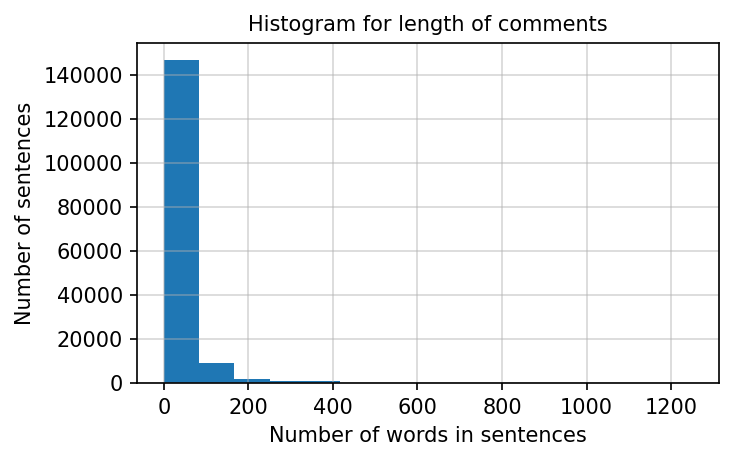

In [122]:
# Plotting the histogram
plt.figure(figsize=(5, 3), dpi=150)
plt.hist(corpus_clean_len, bins=15)
plt.title("Histogram for length of comments", fontsize = 10);
plt.xlabel("Number of words in sentences", fontsize = 10)
plt.ylabel("Number of sentences", fontsize = 10)
plt.grid(alpha=0.5)

We can see from the graph that majority of the sentences have words from 0 to around 150.

#### 2.2 Distribution of class labels

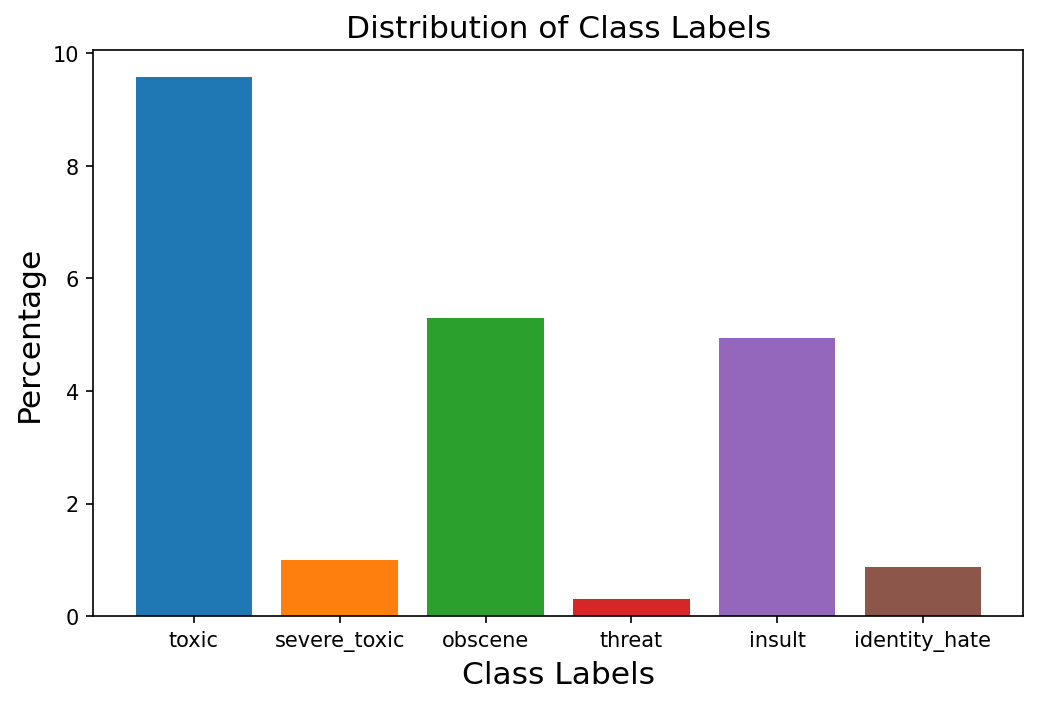

In [125]:
# Calculating distribution of class labels

label_perc_toxic = (train_df['toxic'].sum()/len(train_df))*100
label_perc_severe_toxic = (train_df['severe_toxic'].sum()/len(train_df))*100
label_perc_obscene = (train_df['obscene'].sum()/len(train_df))*100
label_perc_threat = (train_df['threat'].sum()/len(train_df))*100
label_perc_insult = (train_df['insult'].sum()/len(train_df))*100
label_perc_identity_hate = (train_df['identity_hate'].sum()/len(train_df))*100

# Plotting
plt.figure(figsize=(8, 5), dpi=150)
plt.bar('toxic', label_perc_toxic)
plt.bar('severe_toxic', label_perc_severe_toxic)
plt.bar('obscene', label_perc_obscene)
plt.bar('threat', label_perc_threat)
plt.bar('insult', label_perc_insult)
plt.bar('identity_hate', label_perc_identity_hate)


plt.xlabel('Class Labels', fontsize = 15)
plt.ylabel('Percentage', fontsize = 15)
plt.title('Distribution of Class Labels', fontsize = 15)
plt.show()

According to the graph, it is evident that the training data contains a higher proportion of toxic comments compared to other types of comments. Threat comments, on the other hand, are the least prevalent in the dataset. The percentages of obscene and threat comments are relatively similar, indicating a comparable occurrence of these two types. Similarly, severe toxic and identity hate comments exhibit nearly identical percentages in the dataset.

#### 2.3 Exploring User Diversity and Distribution in Comment Dataset

Would like to see whether the "id" pertains to the "userid" or "commentid" as no detail is provided in dataset description. If it corresponds to the "userid," it presents an opportunity to explore the distinctive users who engage in commenting and assess the distribution among them. 

In [75]:
unique_count = train_df['id'].nunique() #checking for unique id
print(unique_count)

159571


Since, all the ids are unique, it is likely to be comment id.  In such a scenario, when a user comments, a new and distinct "id" is assigned to each comment. Hence, conducting additional analysis may not yield significant insights.

#### 2.4 Word Cloud for most frequent words in each class

In [77]:
def wordcloud(df, label):
    
    # Print only rows where the toxic category label value is 1 (ie. the comment is toxic)
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="white", max_words=4000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in class - {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'Accent' , random_state=244), alpha=0.98)

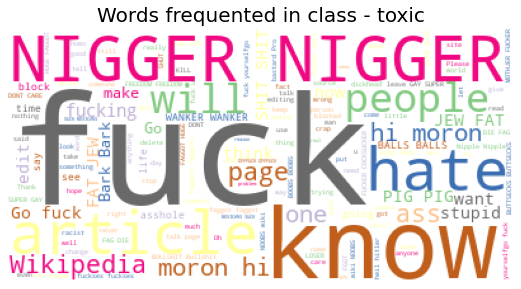

In [78]:
wordcloud(train_df, 'toxic')

Fuck, hate, nigger are the most frequent words in toxic comments

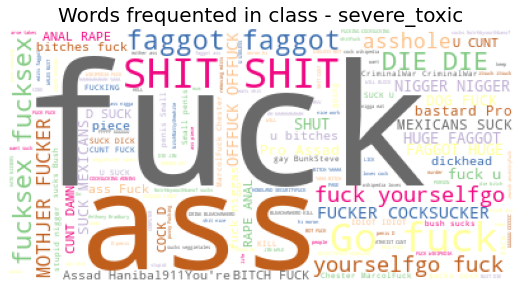

In [79]:
wordcloud(train_df,'severe_toxic')

Fuck, ass, shit, faggot are the most frequent words in severe toxic comment

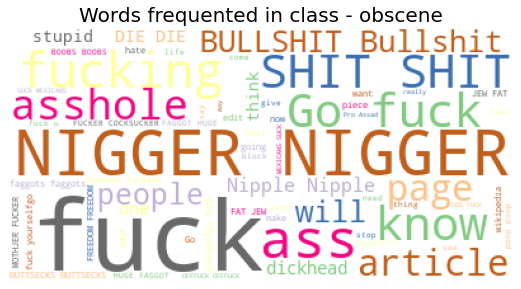

In [80]:
wordcloud(train_df,'obscene')

Fuck, nigger, shit ,asshole are the some of the most frequent words in obscene comment

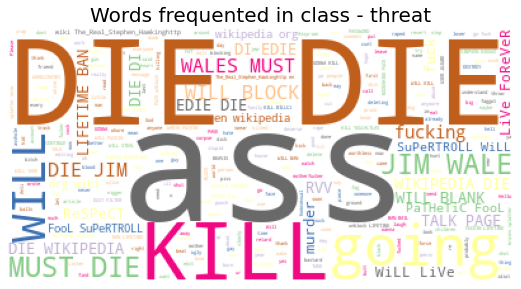

In [81]:
wordcloud(train_df,'threat')

Die, ass, kill are the some of the most frequent words in threat comment

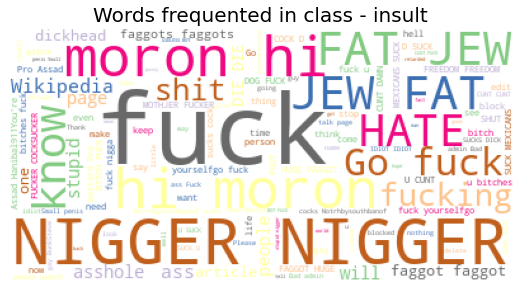

In [82]:
wordcloud(train_df,'insult')

Fuck, nigger, moron, fat, hate are the some of the most frequent words in insult comment

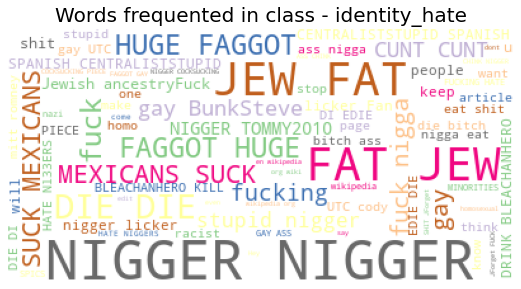

In [83]:
wordcloud(train_df,'identity_hate')

Nigger, Jew, Fat, Faggot, Mexicans the some of the most frequent words in identity hate comment

### Step 3 : Data Preparation

In [88]:
from sklearn.model_selection import train_test_split

# Splitting train_df into training and validation sets
train_data, valid_data = train_test_split(train_df, test_size=0.2, random_state=42)
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

# Printing the sizes of the training and validation datasets
print("Training data size:", len(train_data))
print("Validation data size:", len(valid_data))


Training data size: 127656
Validation data size: 31915


In [94]:
train_data.loc[2010:2014]# Displaying some rows of the train dataset

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
2010,b1b4867d2f5177de,Viriditas appears to be a bit confused about t...,0,0,0,0,0,0
2011,b5df6ecc55bb6a30,You racist gringo! \n\nStop reverting my edit ...,1,0,0,0,1,0
2012,6b0ec5628b8caf6f,block me i don't give a shit,1,0,1,0,0,0
2013,ebbf00e1ebe86f7e,douch bag \n\nThats you.,1,0,0,0,0,0
2014,4fd2dacaa3460def,"""\n\nI think it makes even more sense for a ba...",0,0,0,0,0,0


The dataset clearly demonstrates that it is not only a multiclass dataset but also incorporates multilabel elements. This means that a single comment can be associated with multiple classes simultaneously, as exemplified by indices 2011 and 2012.

#### Using TF-IDF vectorization to convert text data into numerical features

We utilize TF-IDF because it not only considers word frequencies but also provides a measure of word importance. Its key advantage lies in its simplicity, ease of implementation, and computational efficiency, making it a fast and practical choice.

In [95]:
# Initialize the TF-IDF vectorizer for text data
vectorizer = TfidfVectorizer(
    ngram_range=(1, 1), analyzer='word', tokenizer=document_tokenizer, 
    strip_accents='unicode', min_df=10, max_features=1000 
    # document_tokenize is the function we wrote above for data cleaning
)
# Converting the training data comments into TF-IDF feature matrix
X_train = vectorizer.fit_transform(train_data['comment_text'])

# Converting the validation data comments into TF-IDF feature matrix using the already fitted vectorizer
X_valid = vectorizer.transform(valid_data['comment_text'])

# Converting the test data comments into TF-IDF feature matrix using the already fitted vectorizer
X_test = vectorizer.transform(test_data['comment_text'])

/Users/aasthatandon/anaconda3/envs/mlp/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [27]:
X_train.shape # Displaying shape of X_train

(127656, 1000)

### Step 4 : Build Model

#### Method 1 :  Binary Classifiers using Logistic Regression

We will use Binary Relevance which converts multi-label classification tasks into independent binary classification tasks. It is a simple method where each label is treated as a separate classification problem, assuming no correlation between labels. Here we are bulding 6 separate binary classifiers corresponding to 6 types of labels. 

In [96]:
def binary_logistic_classifier(X_train, X_valid, label):
    '''
    function fits a logistic regression model, predicts the target variable, 
    prints accuracy, and returns the model
    '''
    # Creating instance of LogisticReg with regularization strength C=10.0 and max iterations of 1000
    logreg = LogisticRegression(C=10.0, max_iter=1000)
    
    # Assigning the target variable for training data to y_train
    y_train = train_data[label]
    
    # Fiting  the logistic regression model using training data
    logreg.fit(X_train, y_train)
    
     # Assigning the target variable for validation data to y_valid    
    y_valid = valid_data[label]

    # Predicting the target variable for validation data using the trained model
    y_pred = logreg.predict(X_valid)
    
    # Printing the validation accuracy
    print('Validation accuracy is {}'.format(accuracy_score(y_valid, y_pred)))

    # Returning the trained logistic regression model
    return logreg
 

##### Training logistic regression models for each label

In [97]:
target_columns = ('toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate')

# Iterating over each label in the target_columns 
for label in target_columns:
    
    # Printing the current label 
    print("For {}".format(label))
    
    # Training a logistic regression model for the current label
    clf = binary_logistic_classifier(X_train, X_valid,label)

For toxic
Validation accuracy is 0.9535328215572615
For severe_toxic
Validation accuracy is 0.9905373648754504
For obscene
Validation accuracy is 0.9770327432241892
For threat
Validation accuracy is 0.9978066739777534
For insult
Validation accuracy is 0.9684787717374276
For identity_hate
Validation accuracy is 0.9916026946576845


Based on the results above, the validation dataset shows decent accuracy. Labels like severe_toxic, threat, and identity_hate achieved around 99% accuracy. Among all classes, toxic had the lowest prediction accuracy at 95%.

#### Method 2:  Chained Binary Classifiers using Logistic Regression

As a second method for our multi-label classification, we would use classifier chains. 

- It is an approach where the initial classifier is trained on input X. 

- The following classifiers are trained on both X and the predictions from all preceding classifiers in the chain. 

- This method aims to capture correlations among the target variables by incorporating the predictions of previous classifiers. By considering the chain of predictions, it leverages the information from preceding variables to enhance the multi-label classification process.

- Here we would be again bulding 6 separate models for the prediction.

In [99]:
def add_feature(X, feature_to_add):
    '''
    function adds a sparse feature (or a list of features) to a feature matrix 
    and returns the updated matrix
    '''
    
    # Stacking existing feature matrix 'X' horizontally with the transposed sparse feature(s) 'feature_to_add'
    # The resulting matrix is returned in Compressed Sparse Row format ('csr')
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

We would iterate over labels, train models, and adds features to matrices

In [100]:
import copy 

# Create deep copies of the feature matrices
X_train_ = copy.deepcopy(X_train)
X_valid_ = copy.deepcopy(X_valid)

# Iterating over each label in target_columns
for label in target_columns:
    
    # Printing the current label
    print("For {}".format(label))
    
    # Training a logistic regression model for the current label
    clf = binary_logistic_classifier(X_train_, X_valid_, label)
    
    # Extracting the current label column from train_data and assigning it to feature_to_add
    feature_to_add = train_data[label]
    
    #Adding the feature_to_add to the X_train_ matrix
    X_train_ = add_feature(X_train_, feature_to_add)
    
    # Extracting the current label column from valid_data and assigning it to feature_to_add
    feature_to_add = valid_data[label]
    
    # Adding the feature_to_add to the X_valid_ matrix
    X_valid_ = add_feature(X_valid_, feature_to_add)

For toxic
Validation accuracy is 0.9535328215572615
For severe_toxic
Validation accuracy is 0.9906313645621181
For obscene
Validation accuracy is 0.9772520758264139
For threat
Validation accuracy is 0.9979633401221996
For insult
Validation accuracy is 0.9757480808397305
For identity_hate
Validation accuracy is 0.9923546921510261


It has almost similar results like binary relevance.

#### Method 3 : Single MultiClass Classifier using Logistic Regression

We are getting decent accuracy from the above two methods : Binary relevance and Chain binary classifiers, however we are bulding 6 separate models corresponding to each class. In order to overcome this, we want to build a single multiclass classfier model by creating a combined labels. This will faciliatate deployment of single model versus 6 separate models. As an appoach we took the following steps:

- We have a total of six labels: 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', and 'identity_hate'. For multilabel classification, we converted their corresponding values into binary. The range of values goes from 0 ('000000') to 63 ('111111').

- Assigned a decimal value to a new combined label column based on the binary values in each label.
- This resulted in a total of 64 classes for multiclass classification.

- Applied a multiclass linear regression model, allowing us to handle all 64 classes in a single model rather than using six separate binary models

In [101]:
# create class labels from 0 to 63

'''
The code generates class labels for values from 0 to 63 
using binary stringsand creates a reverse mapping.
'''

# Creating empty dictionaryfor class labels
class_labels = {}

# Iterating over values from 0 to 63
for label in range(0, 64):
    
    # Converting the current label to a 6-digit binary string representation
    lb_str = "{0:06b}".format(label)
    
     # Assigning label as value and the binary string as key in the class_labels dictionary
    class_labels[lb_str] = label
    

# Swapping Keys & values in class_labels to create class_labels_reverse to be utilized later 
class_labels_reverse = {v:k for k,v in class_labels.items()}

In [102]:
def assign_label_feat(df):
    '''
    function assigns combined labels to a DataFrame by 
    converting binary representations to decimal of target columns 
    '''
    # Initializing an empty list to store the combined label values
    label_lst=[]
    
    # Iterating over each row in the dataframe
    for idx,row in df.iterrows():
        
        # Initializing empty string to build the binary labels
        label_string = ''
        
        # Iterating over the target columns
        for col in target_columns:
            
            #Appending to the label_string
            label_string = label_string + str(int(row[col]))
            
        # Retrieve the corresponding label value from the class_labels and appending to label_lst
        label_lst.append(class_labels[label_string])
    
    # Creating a dataframe from label_lst with the column name 'combined_label'
    label_df = pd.DataFrame(label_lst, columns = ['combined_label'])
    
    # Concatenating df and label_df along the columns axis
    df = pd.concat([df,label_df],axis=1)
    
    # Returning the updated df
    return df
    


In [103]:
train_data = assign_label_feat(train_data)
valid_data = assign_label_feat(valid_data)

In [104]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,combined_label
0,ed56f082116dcbd0,Grandma Terri Should Burn in Trash \nGrandma T...,1,0,0,0,0,0,32
1,f8e3cd98b63bf401,", 9 May 2009 (UTC)\nIt would be easiest if you...",0,0,0,0,0,0,0
2,a09e1bcf10631f9a,"""\n\nThe Objectivity of this Discussion is dou...",0,0,0,0,0,0,0
3,af0ee0066c607eb8,Shelly Shock\nShelly Shock is. . .( ),0,0,0,0,0,0,0
4,b734772b1a807e09,I do not care. Refer to Ong Teng Cheong talk p...,0,0,0,0,0,0,0


After applying the ```assign_label_feat``` function to the data, we can observe the conversion of binary labels to decimal values in the "combined_label" column. For example, the first row with values 1, 0, 0, 0, 0, 0 in the 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', and 'identity_hate' columns is represented as binary 1000000, which corresponds to a decimal value of 32 in the "combined_label" column.

In [105]:
def multiclass_logistic_classifier(X_train, X_valid, label):
    
    # Creating instance of LogisticReg with regularization C=10.0 and max iterations of 1000
    logreg = LogisticRegression(C=10.0, max_iter=1000)
    
    # Assigning the target variable for training data to y_train
    y_train = train_data[label]
    
    # Fiting  the logistic regression model using training data
    logreg.fit(X_train, y_train)
    
     # Assigning the target variable for validation data to y_valid 
    y_valid = valid_data[label]
    
    # Predicting the target variable for validation data using the trained model
    y_pred = logreg.predict(X_valid)
    
    # Printing the validation accuracy
    print('Validation accuracy is {}'.format(accuracy_score(y_valid, y_pred)))
    
    # Returning the trained logistic regression model
    return logreg

In [106]:
multi_clf = multiclass_logistic_classifier(X_train, X_valid, 'combined_label')

Validation accuracy is 0.9167476108412972


Overall validation accuracy for validation data is around 91.6% over 64 classes. Now we will evaluate seaprately this classifier for each of our 6 original class for fair comparision with previous methods.

In [107]:
def eval_multiclass_clf(clf, X_valid, valid_data, label, name):
    """
    Function to evaluate a trained multiclass classifier.

    Args:
        clf: Trained classifier.
        X_valid: Validation data feature matrix.
        valid_data: Validation data DataFrame.
        label: Target label for evaluation.
        name: Name of the classifier.
    """
    
    # Get the ground truth labels for validation data
    y_valid = valid_data[label]
    
    # Predict the labels for validation data using the trained classifier
    y_pred = clf.predict(X_valid)
    
    # Calculate and print the overall accuracy on all 64 classes
    print('Overall {} accuracy on 64 classes is {}'.format(name, accuracy_score(y_valid, y_pred)))
    
    # Convert the predicted labels to the corresponding binary patterns
    pred_labels = []
    for y in y_pred:
        pred_pattern = class_labels_reverse[y]
        pred_pattern = list(pred_pattern)
        pred_labels_ = [int(p) for p in pred_pattern]
        pred_labels.append(pred_labels_)
        
    # Create column names for the predicted labels
    col_names = ["pred_" + col for col in target_columns]
    
    # Create a DataFrame with the predicted labels
    label_df = pd.DataFrame(pred_labels, columns=col_names)
    
    # Concatenate the predicted labels DataFrame with the original validation data
    valid_data_with_pred = pd.concat([valid_data, label_df], axis=1)
    
    # Evaluate the classifier for each individual class
    for col in target_columns:
        gt = valid_data_with_pred[col]  # Ground truth labels
        pred = valid_data_with_pred["pred_" + col]  # Predicted labels
        
        # Calculate and print the accuracy for each class
        print('{} accuracy for {} is {}'.format(name, col, accuracy_score(gt, pred)))


In [108]:
eval_multiclass_clf(multi_clf, X_valid, valid_data, 'combined_label',name='Validation')

Overall Validation accuracy on 64 classes is 0.9167476108412972
Validation accuracy for toxic is 0.9527181576061413
Validation accuracy for severe_toxic is 0.9894720350932164
Validation accuracy for obscene is 0.9760300798997337
Validation accuracy for threat is 0.9977440075199749
Validation accuracy for insult is 0.9670374432085226
Validation accuracy for identity_hate is 0.9914773617421275


Our single multiclass classifier achieves almost similar results compared to Binary Relevance (Method1) and Chained-Binary Classifiers (Method2), the implementation of a multiclass linear regression model offered notable advantages in handling all 64 classes within a single model.

- Reduced complexity and streamlined approach.
- Efficient inference with predictions for all classes in one pass.
- Unified decision-making by considering relationships between classes.
- Simplified model maintenance and code management.
- Faster and more scalable predictions.

Hence, we have decided to deploy the single multiclass model and evaluate its performance on our test set

### Evaluation on test

In [109]:
test_data_ = assign_label_feat(test_data)

In [110]:
eval_multiclass_clf(multi_clf, X_test, test_data_, 'combined_label', name='Test')

Overall Test accuracy on 64 classes is 0.8955422176373128
Test accuracy for toxic is 0.9331801556785145
Test accuracy for severe_toxic is 0.9923098565131764
Test accuracy for obscene is 0.9591422051330145
Test accuracy for threat is 0.9963268623589359
Test accuracy for insult is 0.9534371190096596
Test accuracy for identity_hate is 0.9898089968426647


The test accuracy for each class closely aligns with the performance we achieved on the validation dataset, indicating a true representation of the model's capabilities. The fact that the accuracy levels are consistent across both validation and test datasets suggests that the model's generalization ability is quite reliable and robust. These results on the test set demonstrate its suitability for real-world applications.